<a href="https://colab.research.google.com/github/suyeonlee333333/oss2025/blob/main/free_rider_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -y install -qq fonts-nanum
!pip install gradio


Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


# 🚇 무임승차 손실 예측 시뮬레이터
기준 연령에 따라 무임인원 → 무임손실액 → 총손실액을 예측하는 모델을 구성합니다.

In [2]:
# 1️⃣ 파일 불러오기
import pandas as pd
file_path = 're_study_data.xlsx'
df = pd.read_excel(file_path)
df.head()

,연도,월,연령,지하철 이용량,고령 인구수,무임인원,무임인원비율,무임손실 (백만),누적손실액
0,2021,1,65,17834292,649577,5419112,0.303859,7586.7568,7586.7568
1,2021,2,65,18431141,652254,5505261,0.298693,7707.3654,15294.1222
2,2021,3,65,23348552,655874,7028495,0.301025,9839.8930,25134.0152
3,2021,4,65,22250031,658150,6783118,0.304859,9496.3652,34630.3804
4,2021,5,65,22606497,660561,6864538,0.303653,9610.3532,44240.7336


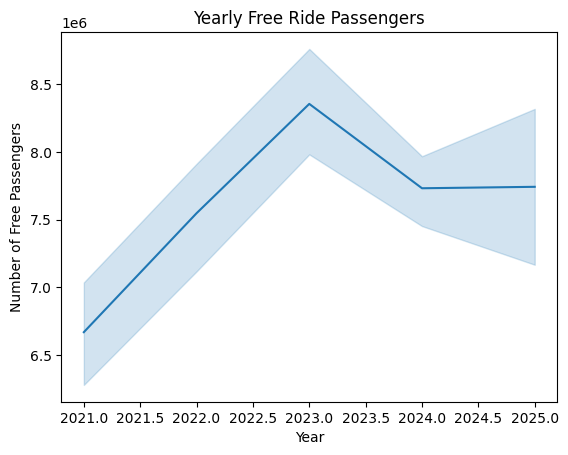

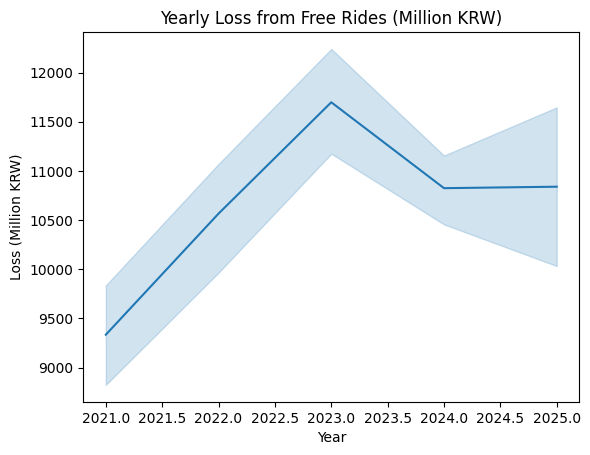

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 컬럼명 영어로 변경 (이미 하신 부분 포함)
df = df.rename(columns={
    '연도': 'Year',
    '월': 'Month',
    '연령': 'Age',
    '지하철 이용량': 'SubwayUsage',
    '고령 인구수': 'SeniorPopulation',
    '무임인원': 'FreeRidePassengers',
    '무임인원비율': 'FreeRideRatio',
    '무임손실 (백만)': 'LossFromFreeRides_MillionKRW',
    '누적손실액': 'CumulativeLoss_MillionKRW'
})

# ✅ 기본 영어 폰트 설정 및 마이너스 깨짐 방지
plt.rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False

# ✅ 시각화 1: Year vs Free Passengers
sns.lineplot(data=df, x='Year', y='FreeRidePassengers')
plt.title('Yearly Free Ride Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Free Passengers')
plt.show()

# ✅ 시각화 2: Year vs Free Ride Loss
sns.lineplot(data=df, x='Year', y='LossFromFreeRides_MillionKRW')
plt.title('Yearly Loss from Free Rides (Million KRW)')
plt.xlabel('Year')
plt.ylabel('Loss (Million KRW)')
plt.show()


Year별 무임승차 인원 추이

x축: 연도 (Year)

y축: 무임승차 인원 (FreeRidePassengers)

선 그래프로 연도별 무임승차 인원 변화 흐름을 보여줌

Year별 무임승차 손실액 추이

x축: 연도 (Year)

y축: 무임손실액 (LossFromFreeRides_MillionKRW)

선 그래프로 연도별 무임승차 손실액 변화를 시각화

📊 MSE (Mean Squared Error): 202861937674.36514
📈 R² score (결정계수): 0.5920663356791809


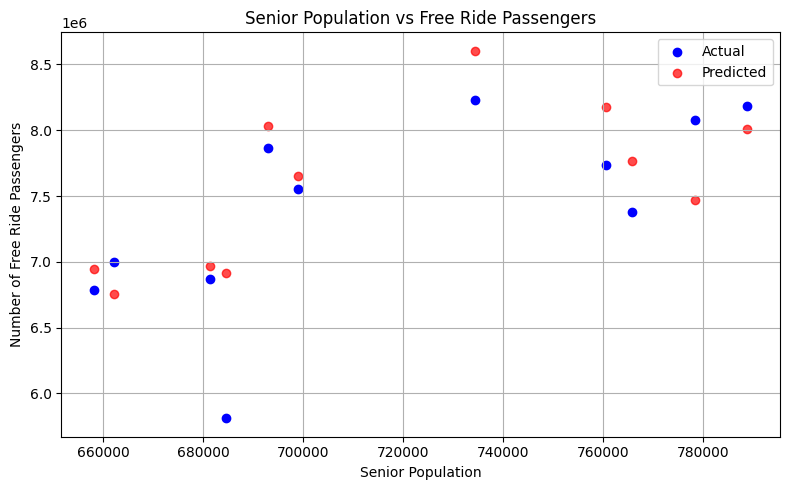

       SeniorPopulation  FreeRidePassengers
count         52.000000        5.200000e+01
mean      718070.538462        7.588489e+06
std        41720.649110        8.678786e+05
min       649577.000000        5.419112e+06
25%       683742.750000        7.020428e+06
50%       717977.000000        7.614680e+06
75%       753714.250000        8.189665e+06
max       791720.000000        9.620908e+06


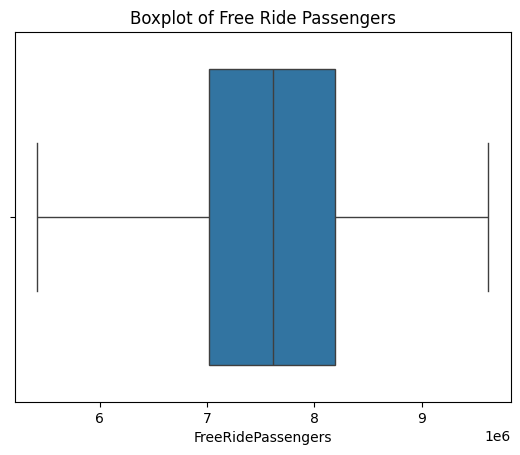

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ✔️ matplotlib 기본 설정 복구 (폰트 깨짐 방지)
mpl.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='DejaVu Sans')

# ✔️ X: 고령인구수 / y: 무임인원
X = df[['SeniorPopulation']]
y = df['FreeRidePassengers']

# ✔️ 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✔️ 랜덤포레스트 회귀 모델 생성 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✔️ 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 MSE (Mean Squared Error):", mse)
print("📈 R² score (결정계수):", r2)

# ✔️ 시각화: 실제값 vs 예측값
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, label='Actual', color='blue')
plt.scatter(X_test, y_pred, label='Predicted', color='red', alpha=0.7)  # 선형회귀처럼 선은 아니고 산점도로 표시
plt.xlabel('Senior Population')
plt.ylabel('Number of Free Ride Passengers')
plt.title('Senior Population vs Free Ride Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✔️ 통계 정보 확인
print(df[['SeniorPopulation', 'FreeRidePassengers']].describe())

# ✔️ 이상치 확인 (boxplot)
sns.boxplot(data=df, x='FreeRidePassengers')
plt.title('Boxplot of Free Ride Passengers')
plt.show()


고령 인구 수(SeniorPopulation)가 많을수록 무임승차 인원(FreeRidePassengers)이 어떻게 변하는지

| 항목          | SeniorPopulation      | FreeRidePassengers     |
| ----------- | --------------------- | ---------------------- |
| count       | 52 (데이터 개수)           | 52 (데이터 개수)            |
| mean        | 약 718,070명 (평균)       | 약 7,588,489명 (평균)      |
| std (표준편차)  | 약 41,720 (데이터 흩어진 정도) | 약 867,879 (데이터 흩어진 정도) |
| min         | 649,577명 (최소값)        | 5,419,112명 (최소값)       |
| 25% (1사분위수) | 683,742명              | 7,020,428명             |
| 50% (중앙값)   | 717,977명              | 7,614,680명             |
| 75% (3사분위수) | 753,714명              | 8,189,665명             |
| max         | 791,720명 (최대값)        | 9,620,908명 (최대값)       |


MSE: 6551.029059827648
R² score: 0.9932788678940853


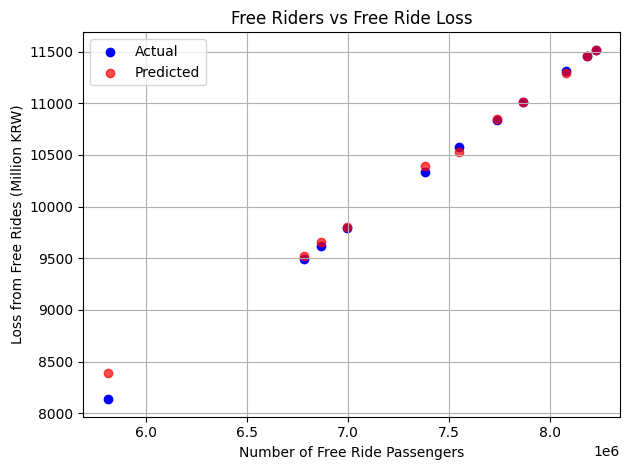

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Feature, Target 정의
X2 = df[['FreeRidePassengers']]
y2 = df['LossFromFreeRides_MillionKRW']

# 2. 학습/테스트 분할
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# 3. 랜덤포레스트 회귀 모델 학습
model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2.fit(X_train2, y_train2)

# 4. 예측 및 평가
y_pred2 = model_2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r2_2 = r2_score(y_test2, y_pred2)

print("MSE:", mse2)
print("R² score:", r2_2)

# 랜덤포레스트는 계수(coef_)와 절편(intercept_)가 없어서 출력하지 않습니다.

# 5. 시각화
plt.scatter(X_test2, y_test2, label='Actual', color='blue')
plt.scatter(X_test2, y_pred2, label='Predicted', color='red', alpha=0.7)  # 예측값 산점도로 표시
plt.xlabel('Number of Free Ride Passengers')
plt.ylabel('Loss from Free Rides (Million KRW)')
plt.title('Free Riders vs Free Ride Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**무임승차 인원 수가 증가할수록 손실액도 증가하는지(선형 관계) 분석하는 코드**

X2 : 독립 변수(입력 데이터) → 무임승차 인원 수 (FreeRidePassengers)

y2 : 종속 변수(목표값) → 무임승차로 인한 손실액 (LossFromFreeRides_MillionKRW)


데이터를 학습용과 테스트용으로 8:2 비율로 나누어 모델 학습과 평가에 사용


LinearRegression() 모델 생성 후 학습 데이터로 학습


테스트 데이터에 대한 예측값 생성

평균 제곱 오차(MSE)와 결정계수(R²)를 계산해 모델 성능 평가

회귀식의 기울기(계수)와 절편도 출력


실제 값(y_test2)과 예측 값(y_pred2)을 그래프로 비교

파란 점: 실제 데이터

빨간 선: 예측 선형 모델

Predicted cumulative loss: [13097.578956 16026.377808 41427.212736 34815.315892 38832.328276]


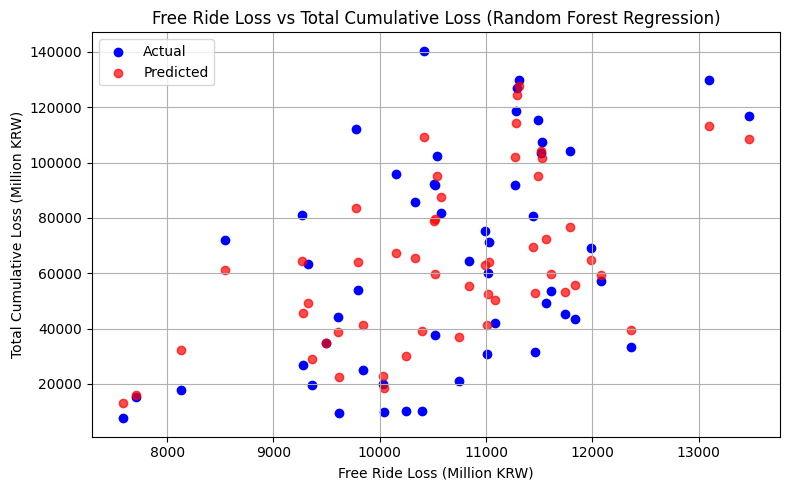

Mean Squared Error (MSE): 209478502.43122423
R² Score: 0.8555724400012124


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Feature / Target 정의
X3 = df[['LossFromFreeRides_MillionKRW']]     # 단위: 백만 원
y3 = df['CumulativeLoss_MillionKRW']          # 누적 손실액

# 2. 모델 생성 및 학습
model_3 = RandomForestRegressor(n_estimators=100, random_state=42)
model_3.fit(X3, y3)

# 3. 예측
y_pred = model_3.predict(X3)
print("Predicted cumulative loss:", y_pred[:5])  # 상위 5개 예측값만 출력

# 4. 시각화
plt.figure(figsize=(8, 5))
plt.scatter(X3, y3, label='Actual', color='blue')
plt.scatter(X3, y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Free Ride Loss (Million KRW)')
plt.ylabel('Total Cumulative Loss (Million KRW)')
plt.title('Free Ride Loss vs Total Cumulative Loss (Random Forest Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. 평가 지표
mse = mean_squared_error(y3, y_pred)
r2 = r2_score(y3, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)



X3: 무임승차 손실액 (백만 원 단위)

y3: 누적 손실액 (백만 원 단위)


LinearRegression() 객체 생성 후 X3, y3로 학습(fit)


학습 데이터 X3로 바로 예측값 계산 (y_pred)

상위 5개 예측값 출력해서 대략적인 예측 결과 확인

산점도(파란 점): 실제 누적 손실액

선 그래프(빨간 선): 모델 예측 누적 손실액

x축: 무임승차 손실액, y축: 누적 손실액

선형관계가 어떻게 나타나는지 확인 가능

MSE (평균 제곱 오차)

R² 점수 (결정계수) → 1에 가까울수록 설명력 좋음

   YearMonth  AgeThreshold  EstimatedFreeRidePassengers  EstimatedLoss  \
0 2021-01-01            65                      5419112           7740   
1 2021-01-01            70                      3497261           7740   
2 2021-01-01            75                      2088893           7740   
3 2021-01-01            80                      1077253           7740   
4 2021-01-01            85                       420447           7740   

   EstimatedTotalLoss  
0               16026  
1               16026  
2               16026  
3               16026  
4               16026  


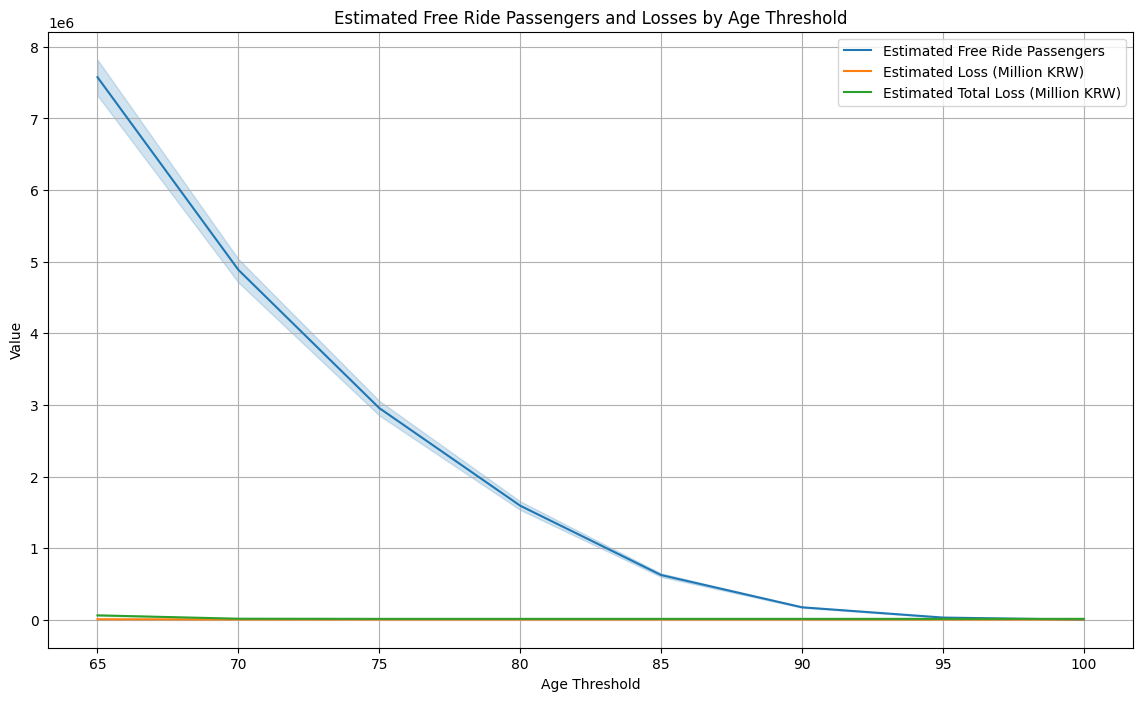

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 주 시트 데이터 불러오기
df = pd.read_excel('re_study_data.xlsx')

# 2. 컬럼명 영어로 변경
df = df.rename(columns={
    '연령': 'Age',
    '무임인원': 'FreeRidePassengers',
    '무임손실 (백만)': 'LossFromFreeRides_MillionKRW',
    '누적손실액': 'CumulativeLoss_MillionKRW',
    '고령 인구수': 'SeniorPopulation',
    '지하철 이용량': 'SubwayUsage',
    '연도': 'Year',
    '월': 'Month'
})

# 3. YearMonth 생성 (연도 + 월 → 날짜 포맷)
df['YearMonth'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2))

# 4. 모델 1: Age → FreeRidePassengers (사용 안 하고 있지만 참고용)
# (생략 - 필요 시 RandomForest로 변경 가능)

# 5. 모델 2: FreeRidePassengers → LossFromFreeRides_MillionKRW
X2 = df[['FreeRidePassengers']]
y2 = df['LossFromFreeRides_MillionKRW']
model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2.fit(X2, y2)

# 6. 모델 3: LossFromFreeRides_MillionKRW → CumulativeLoss_MillionKRW
X3 = df[['LossFromFreeRides_MillionKRW']]
y3 = df['CumulativeLoss_MillionKRW']
model_3 = RandomForestRegressor(n_estimators=100, random_state=42)
model_3.fit(X3, y3)

# 7. 월별 인구 수 시트 불러오기 및 전처리
age_raw = pd.read_excel('re_study_data.xlsx', sheet_name='월별 인구 수')
age_raw.drop(columns=age_raw.columns[1], inplace=True)
age_raw.rename(columns={age_raw.columns[0]: 'YearMonth'}, inplace=True)
age_raw = age_raw[~age_raw['YearMonth'].astype(str).str.contains('합')]
age_raw['YearMonth'] = pd.to_datetime(age_raw['YearMonth'], errors='coerce')
age_raw = age_raw.dropna(subset=['YearMonth'])
age_raw['Year'] = age_raw['YearMonth'].dt.year
age_raw['Month'] = age_raw['YearMonth'].dt.month

# 8. 2021~2024 필터링
filtered_df = age_raw[(age_raw['Year'] >= 2021) & (age_raw['Year'] <= 2024)]

# 9. 요약 시트 불러오기 및 연월 생성
summary_df = pd.read_excel('re_study_data.xlsx', sheet_name=0)
summary_df = summary_df.rename(columns={
    '무임인원': 'FreeRidePassengers',
    '지하철 이용량': 'SubwayUsage',
    '연도': 'Year',
    '월': 'Month'
})
summary_df['YearMonth'] = pd.to_datetime(summary_df['Year'].astype(str) + '-' + summary_df['Month'].astype(str).str.zfill(2))

# 10. 병합
merged_df = pd.merge(
    filtered_df,
    summary_df[['YearMonth', 'FreeRidePassengers', 'SubwayUsage']],
    on='YearMonth',
    how='left'
)

# 11. 추정 함수들

def estimate_free_riders_by_virtual_policy(age, df, total_free_riders):
    total_old_population = df['SeniorPopulation'].sum()
    eligible_df = df[df['Age'] >= age]
    if eligible_df.empty or total_old_population == 0:
        return 0
    eligible_population = eligible_df['SeniorPopulation'].sum()
    eligible_ratio = eligible_population / total_old_population
    estimated_free_riders = total_free_riders * eligible_ratio
    return estimated_free_riders


def simulate_loss(age, df, total_free_riders):
    count = estimate_free_riders_by_virtual_policy(age, df, total_free_riders)
    if count == 0:
        return 0, 0, 0
    loss = model_2.predict(pd.DataFrame({'FreeRidePassengers': [count]}))[0]
    total = model_3.predict(pd.DataFrame({'LossFromFreeRides_MillionKRW': [loss]}))[0]
    return count, loss, total

# 12. 시뮬레이션 실행
results = []

for idx, row in merged_df.iterrows():
    year_month = row['YearMonth']
    total_passengers = row['SubwayUsage']
    total_free_riders = row['FreeRidePassengers']

    age_data = row.filter(regex=r'^\d+$')
    age_data.index = age_data.index.astype(int)

    df_month = pd.DataFrame({
        'Age': age_data.index,
        'SeniorPopulation': age_data.values,
        'FreeRidePassengers': [0] * len(age_data),
        'SubwayUsage': total_passengers
    })

    for age_threshold in range(65, 101, 5):
        count, loss, total = simulate_loss(age_threshold, df_month, total_free_riders)
        results.append({
            'YearMonth': year_month,
            'AgeThreshold': age_threshold,
            'EstimatedFreeRidePassengers': round(count),
            'EstimatedLoss': round(loss),
            'EstimatedTotalLoss': round(total)
        })

# 13. 결과 출력
results_df = pd.DataFrame(results)
print(results_df.head())

# 시각화: AgeThreshold별 EstimatedFreeRidePassengers, EstimatedLoss, EstimatedTotalLoss 추이
plt.figure(figsize=(14, 8))

sns.lineplot(data=results_df, x='AgeThreshold', y='EstimatedFreeRidePassengers', label='Estimated Free Ride Passengers')
sns.lineplot(data=results_df, x='AgeThreshold', y='EstimatedLoss', label='Estimated Loss (Million KRW)')
sns.lineplot(data=results_df, x='AgeThreshold', y='EstimatedTotalLoss', label='Estimated Total Loss (Million KRW)')

plt.title('Estimated Free Ride Passengers and Losses by Age Threshold')
plt.xlabel('Age Threshold')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



**estimate_free_riders_by_virtual_policy 함수**: 특정 연령 이상 노인 인구 비율을 계산해 무임승차 인원을 가상 추정

그 추정을 바탕으로 학습된 선형회귀 모델로 무임손실액과 누적손실액을 추정

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import gradio as gr

# 데이터 불러오기 및 컬럼명 정리 (생략, 기존 코드 그대로)

# 모델 1: Age → FreeRidePassengers (랜덤 포레스트)
X1 = df[['Age']]
y1 = df['FreeRidePassengers']
model_1 = RandomForestRegressor(random_state=42)
model_1.fit(X1, y1)

# 모델 2: FreeRidePassengers → LossFromFreeRides_MillionKRW (랜덤 포레스트)
X2 = df[['FreeRidePassengers']]
y2 = df['LossFromFreeRides_MillionKRW']
model_2 = RandomForestRegressor(random_state=42)
model_2.fit(X2, y2)

# 모델 3: LossFromFreeRides_MillionKRW → CumulativeLoss_MillionKRW (랜덤 포레스트)
X3 = df[['LossFromFreeRides_MillionKRW']]
y3 = df['CumulativeLoss_MillionKRW']
model_3 = RandomForestRegressor(random_state=42)
model_3.fit(X3, y3)

# 📌 [3] 월별 고령 인구 수 데이터 전처리
# '월별 인구 수' 시트에서 필요한 데이터만 추출하여 최근 고령 인구 구조 파악
age_raw = pd.read_excel('re_study_data.xlsx', sheet_name='월별 인구 수')
age_raw.drop(columns=age_raw.columns[1], inplace=True)
age_raw.rename(columns={age_raw.columns[0]: 'YearMonth'}, inplace=True)
age_raw = age_raw[~age_raw['YearMonth'].astype(str).str.contains('합')]
age_raw['YearMonth'] = pd.to_datetime(age_raw['YearMonth'], errors='coerce')
age_raw.dropna(subset=['YearMonth'], inplace=True)
age_raw['Year'] = age_raw['YearMonth'].dt.year
age_raw['Month'] = age_raw['YearMonth'].dt.month

# 📌 [4] 최근 월 데이터를 기준으로 고령 인구 수를 나이대별로 추출
# 마지막 행(가장 최근 월)에서 60세 이상 인구 정보를 가져옴
latest_row = age_raw.sort_values('YearMonth').iloc[-1]
age_data = latest_row.filter(regex=r'^\d+$')  # 숫자로 시작하는 컬럼만 (연령 컬럼)
age_data.index = age_data.index.astype(int)

# 고령 인구 수 데이터프레임 생성
df_population = pd.DataFrame({
    'Age': age_data.index,
    'SeniorPopulation': age_data.values
})

# 📌 [5] 기준 연령(age_threshold)에 따라 시뮬레이션 실행 함수
# 선택한 연령 이상 인구 비율에 따라 예상 무임승차 인원, 손실액, 누적 손실액을 예측
def simulate_by_age_threshold(age_threshold):
    total_old_population = df_population['SeniorPopulation'].sum()
    eligible_df = df_population[df_population['Age'] >= age_threshold]

    # 유효한 대상 인구가 없으면 0 반환
    if eligible_df.empty or total_old_population == 0:
        return 0, 0, 0

    # 전체 고령 인구 중 기준 연령 이상 비율 계산
    eligible_population = eligible_df['SeniorPopulation'].sum()
    ratio = eligible_population / total_old_population

    # 평균 무임승차 인원 × 해당 비율 = 예상 무임승차 인원
    avg_free_riders = df['FreeRidePassengers'].mean()
    est_free_riders = avg_free_riders * ratio

    # 모델을 이용한 손실 및 누적 손실 예측
    est_loss = model_2.predict([[est_free_riders]])[0]
    est_cum_loss = model_3.predict([[est_loss]])[0]

    return round(est_free_riders), round(est_loss), round(est_cum_loss)

# 📌 [6] Gradio에서 사용할 실행 함수
# 시뮬레이션 결과를 보기 좋게 문자열로 포맷해서 반환
def run_simulation(age_threshold):
    riders, loss, cum_loss = simulate_by_age_threshold(age_threshold)
    return [
        f"{riders:,}명",
        f"{loss:,}백만 원",
        f"{cum_loss:,}백만 원"
    ]

# 📌 [7] Gradio 인터페이스 정의
# 나이 슬라이더로 기준 연령을 조절하면 예측 결과가 텍스트로 출력됨
demo = gr.Interface(
    fn=run_simulation,
    inputs=gr.Slider(60, 100, step=1, value=65, label="무임승차 기준 연령"),
    outputs=[
        gr.Text(label="예상 무임승차 인원"),
        gr.Text(label="예상 손실액 (백만 원)"),
        gr.Text(label="예상 누적 손실액 (백만 원)")
    ],
    title="무임승차 연령 정책 시뮬레이터",
    description="기준 연령을 조정했을 때 예상 무임승차 인원, 손실액, 누적 손실액을 확인해보세요."
)

# 📌 [8] 실행
# 로컬 서버에서 웹앱 실행
demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9dab91e557f1b3e77a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Age → FreeRidePassengers (나이로 무임승차 인원 예측)

FreeRidePassengers → LossFromFreeRides_MillionKRW (무임승차 인원으로 무임손실액 예측)

LossFromFreeRides_MillionKRW → CumulativeLoss_MillionKRW (무임손실액으로 누적손실액 예측)

estimate_free_riders_by_virtual_policy(age_threshold, df_population, total_free_riders)
특정 나이 이상 노인이 전체 고령인구에서 차지하는 비율을 계산하여 가상의 무임승차 인원 추정

simulate_loss(age_threshold, df_population, total_free_riders)
위 추정 무임승차 인원을 바탕으로 손실액과 누적손실액을 선형회귀 모델로 예측